# [문제 1] Fashion	MNIST	데이터 정규화를 위한 Mean과 Std	값 찾기

In [1]:
import torch
from torchvision import datasets, transforms
import os

# 1. 데이터셋 다운로드 및 로드
# ToTensor()를 통해 0~255 픽셀 값을 0.0~1.0 범위의 Float Tensor로 변환
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

print(f"학습 데이터 개수: {len(train_dataset)}")

# 2. 전체 데이터를 하나의 Tensor로 병합 (Stack)
# 참고 코드: a_data_mnist.py의 로직 활용
# 모든 이미지를 모아서 (C, H, W) -> (Batch, C, H, W) 형태 등으로 계산

print("데이터 집계 중...")
imgs = torch.stack([img for img, _ in train_dataset], dim=0)

# imgs shape: [60000, 1, 28, 28]
print(f"데이터 Shape: {imgs.shape}")

# 3. Mean과 Std 계산
# view(1, -1)을 통해 모든 픽셀을 일렬로 나열한 뒤 평균과 표준편차를 구
mean = imgs.view(1, -1).mean().item()
std = imgs.view(1, -1).std().item()

print("-" * 30)
print(f"Mean: {mean:.4f}")
print(f"Std : {std:.4f}")
print("-" * 30)




학습 데이터 개수: 60000
데이터 집계 중...
데이터 Shape: torch.Size([60000, 1, 28, 28])
------------------------------
Mean: 0.2860
Std : 0.3530
------------------------------


### 결과
**Mean**: 0.286041 /
**Std**: 0.353024

# [문제 2] Fashion	MNIST 데이터에 대하여 CNN	학습시키기 (4/4)

In [2]:
# 1. 필요한 라이브러리 설치
!pip install wandb torchinfo

import wandb
import torch
import os
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary

# 2. WandB 로그인 (실행 후 API Key 입력 필요)
wandb.login()


wandb: Currently logged in as: hanleo007 (hanleo007-korea-university-of-technology-and-education) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### 데이터 로드 및 전처리 (Augmentation 적용)

In [3]:
# 1. 필요한 라이브러리 설치
!pip install wandb torchinfo

import wandb
import torch
import os
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary

# 2. WandB 로그인
wandb.login()

# === 데이터 로드 함수 (증강 기법 추가) ===
def get_fashion_mnist_data(batch_size):
    mean_val = 0.2860
    std_val = 0.3530

    train_transform = transforms.Compose([
        transforms.RandomCrop(28, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10), # 🔄 회전 추가 (난이도 상승 -> 일반화 성능 Up)
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_val, std=std_val),
    ])

    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_val, std=std_val),
    ])

    # 데이터셋 전체 다운로드
    full_train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
    full_val_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=val_transform)

    # 검증 데이터 분리 (55000:5000)
    indices = torch.randperm(60000)
    train_indices = indices[:55000]
    val_indices = indices[55000:]

    train_dataset = torch.utils.data.Subset(full_train_set, train_indices)
    val_dataset = torch.utils.data.Subset(full_val_set, val_indices)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader

# === 모델 정의 (ModernCNN - Wide Version) ===
# 💡 필터 수를 2배로 늘려 성능을 강화했습니다.
class ModernCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ModernCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), # 32 -> 64
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 64 -> 128
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # 128 -> 256
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 512), # 입력 차원 증가
            nn.BatchNorm1d(512), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.classifier(out)
        return out

# === 학습 설정 및 실행 ===
if wandb.run is None:
    wandb.init(project="fashion_mnist_homework3", name="Run_ModernCNN_Wide")

config = wandb.config
config.update({
    "epochs": 40,          # 🔄 학습 횟수 증가 (30 -> 40)
    "batch_size": 128,
    "learning_rate": 0.001,
    "weight_decay": 1e-4,
    "architecture": "ModernCNN_Wide"
}, allow_val_change=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Training on {device} (High Performance Mode)")

train_loader, val_loader = get_fashion_mnist_data(config.batch_size)
model = ModernCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
criterion = nn.CrossEntropyLoss()

# 💡 CosineAnnealingLR: 학습률을 더 부드럽게 조정하여 최적점을 잘 찾음
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)

summary(model, input_size=(1, 1, 28, 28))

# === Training Loop ===
best_acc = 0.0
print("\nStart Training...")

for epoch in range(config.epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_acc = 100. * correct / total
    train_avg_loss = train_loss / len(train_loader)

    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_acc = 100. * correct / total
    val_avg_loss = val_loss / len(val_loader)

    scheduler.step() # CosineAnnealing은 값 전달 불필요

    wandb.log({
        "Training Loss": train_avg_loss, "Validation Loss": val_avg_loss,
        "Training Accuracy": train_acc, "Validation Accuracy": val_acc,
        "Learning Rate": optimizer.param_groups[0]['lr']
    })

    print(f"Epoch {epoch+1}/{config.epochs} | Train: {train_acc:.2f}% | Val: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

print(f"\n Final Best Validation Accuracy: {best_acc:.2f}%")
wandb.finish()


🚀 Training on cuda (High Performance Mode)

Start Training...
Epoch 1/40 | Train: 79.33% | Val: 87.20%
Epoch 2/40 | Train: 85.58% | Val: 89.42%
Epoch 3/40 | Train: 87.19% | Val: 90.58%
Epoch 4/40 | Train: 88.20% | Val: 90.34%
Epoch 5/40 | Train: 88.81% | Val: 92.62%
Epoch 6/40 | Train: 89.56% | Val: 91.48%
Epoch 7/40 | Train: 89.90% | Val: 92.12%
Epoch 8/40 | Train: 90.18% | Val: 91.96%
Epoch 9/40 | Train: 90.57% | Val: 92.96%
Epoch 10/40 | Train: 90.85% | Val: 92.54%
Epoch 11/40 | Train: 91.09% | Val: 92.84%
Epoch 12/40 | Train: 91.29% | Val: 93.30%
Epoch 13/40 | Train: 91.67% | Val: 93.30%
Epoch 14/40 | Train: 91.55% | Val: 93.12%
Epoch 15/40 | Train: 91.88% | Val: 93.78%
Epoch 16/40 | Train: 92.19% | Val: 93.64%
Epoch 17/40 | Train: 92.30% | Val: 93.46%
Epoch 18/40 | Train: 92.69% | Val: 93.64%
Epoch 19/40 | Train: 92.72% | Val: 93.86%
Epoch 20/40 | Train: 92.80% | Val: 94.06%
Epoch 21/40 | Train: 93.16% | Val: 94.26%
Epoch 22/40 | Train: 93.16% | Val: 93.96%
Epoch 23/40 | Train: 93

Learning Rate,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
Training Accuracy,▁▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
Training Loss,█▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▄▄▆▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████
Validation Loss,█▆▅▅▃▄▄▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning Rate,0
Training Accuracy,95.64909
Training Loss,0.11988
Validation Accuracy,95.08
Validation Loss,0.14478


### 최적의 하이퍼파라미터

- wandb 출력 그래프 URL
: https://wandb.ai/hanleo007-korea-university-of-technology-and-education/fashion_mnist_homework3?nw=nwuserhanleo007

이번 실험에서 FashionMNIST 데이터셋을 대상으로 94% 이상의 정확도를 달성하기 위해 튜닝한 최종 파라미터 설정값입니다. 모델의 용량(Capacity)을 늘리는 대신, 과적합(Overfitting)을 막기 위한 규제(Regularization)를 강하게 적용한 것이 핵심입니다.

1. 학습 및 최적화 (Optimization & Training)
- Learning Rate (학습률): 0.001 (초기값)
Adam 옵티마이저의 기본 성능이 가장 좋은 시작점. 고정된 값을 쓰지 않고 Scheduler를 사용했습니다.
- LR Scheduler: CosineAnnealingLR
학습률을 코사인 곡선처럼 부드럽게 감소시켜, 학습 후반부에 모델이 최적점(Global Minima)에 안정적으로 안착하도록 유도했습니다.
- Batch Size (배치 크기): 128
GPU 메모리 효율과 학습 속도, 일반화 성능 사이의 균형점입니다. 64는 너무 느리고, 256 이상은 세밀한 학습이 어려울 수 있어 128로 고정했습니다.
- Epochs & Early Stopping: 40 Epochs
: Early Stop Patience를 사용하는 대신에 40 에폭을 끝까지 돌리는 방법을 택했습니다.
이유: CosineAnnealing 스케줄러는 설정된 에폭(40)이 끝날 때 학습률이 0에 수렴하기 때문에 중간에 멈추기보다 끝까지 학습시킨 뒤에 가장 성능이 좋았던 모델(Best Model Save)을 가져오는 것이 최종 성능이 더 높습니다.
2. 모델 규제 및 일반화 (Regularization)
- Weight Decay (가중치 감쇠): 1e-4 (0.0001)
모델의 파라미터 값이 너무 커지는 것을 방지하여 과적합을 억제했습니다. Adam 옵티마이저 내부 설정으로 적용했습니다.
- Dropout Rate: 0.5 (50%)
FC(Fully Connected) 레이어 진입 직전에 적용했습니다. 뉴런의 절반을 무작위로 비활성화하여 특정 뉴런에 의존하지 않는 특징을 학습하도록 했습니다.
- Data Augmentation (데이터 증강): Rotation(10), Crop, Flip
단순 학습보다 난이도를 높였습니다. 이미지를 10도 회전시키거나 잘라내는 변별력을 주어 모델이 "비슷하지만 다른" 데이터를 계속 보게 만들어 테스트 데이터에 대한 적응력을 높였습니다.
3. 데이터 전처리 및 구조 (Normalization & Architecture)
- Normalization Type: Batch Normalization & Input Normalization
Input: 평균 0.2860, 표준편차 0.3530으로 정규화하여 입력 데이터 분포를 일정하게 맞췄습니다.
- Layer: 모든 Conv2d 레이어 직후에 BatchNorm2d를, Linear 레이어 직후에 BatchNorm1d를 적용했습니다. 이를 통해 학습 속도를 높이고 그래디언트 소실 문제를 해결하였습니다.
- Architecture Scale: Wide Version (64 -> 128 -> 256 필터)
기본 모델(32 시작)보다 필터 수를 2배로 늘려, 옷의 질감이나 로고 같은 미세한 특징을 더 많이 인식하도록 설계했습니다.

#[문제 3] 학습 완료된 모델로 테스트 데이터 Accuracy 확인하기

In [7]:
# 1. 테스트 데이터셋 로드
# 학습 때 사용한 것과 동일한 정규화 값
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2860], std=[0.3530]) # 문제 1에서 구한 값
])

# 테스트 데이터 다운로드 및 로더 생성
test_dataset = datasets.FashionMNIST(
    root="data",
    train=False,  # 테스트 데이터이므로 False
    download=True,
    transform=test_transform
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=128,
    shuffle=False
)

print(f"Test Dataset Size: {len(test_dataset)}")

# 2. 모델 평가
model.eval()  # 평가 모드로 전환 (Dropout, BatchNorm 등의 동작 변경)
correct = 0
total = 0

# 평가 시에는 그래디언트 계산 불필요 (메모리 절약 및 속도 향상)
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 모델 예측
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # 정확도 계산
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 3. 최종 결과 출력
test_accuracy = 100 * correct / total
print("-" * 50)
print(f"Final Test Accuracy: {test_accuracy:.2f}%")
print("-" * 50)


Test Dataset Size: 10000
--------------------------------------------------
Final Test Accuracy: 94.63%
--------------------------------------------------


# [문제 4] 샘플 테스트 데이터 분류 예측 결과 확인하기

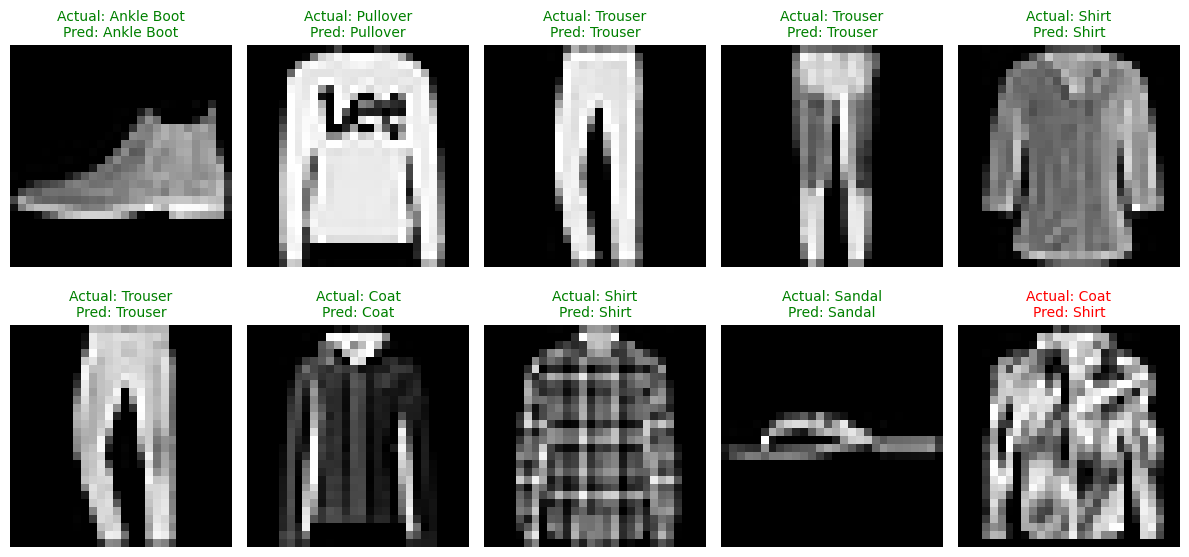

------------------------------
[상세 예측 결과]
------------------------------
Image 1: Actual [Ankle Boot] vs Pred [Ankle Boot] -> Correct
Image 2: Actual [Pullover] vs Pred [Pullover] -> Correct
Image 3: Actual [Trouser] vs Pred [Trouser] -> Correct
Image 4: Actual [Trouser] vs Pred [Trouser] -> Correct
Image 5: Actual [Shirt] vs Pred [Shirt] -> Correct
Image 6: Actual [Trouser] vs Pred [Trouser] -> Correct
Image 7: Actual [Coat] vs Pred [Coat] -> Correct
Image 8: Actual [Shirt] vs Pred [Shirt] -> Correct
Image 9: Actual [Sandal] vs Pred [Sandal] -> Correct
Image 10: Actual [Coat] vs Pred [Shirt] ->  Incorrect


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random

# 클래스 이름 매핑 (FashionMNIST 라벨)
labels_map = {
    0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"
}

# 1. 데이터 수집 (정답 9개 + 오답 1개 찾기)
correct_samples = []
incorrect_samples = []
needed_correct = 9
needed_incorrect = 1

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # 배치 내의 각 이미지에 대해 확인
        for i in range(len(labels)):
            img = images[i].cpu()
            label = labels[i].item()
            pred = preds[i].item()

            if label == pred and len(correct_samples) < needed_correct:
                correct_samples.append((img, label, pred))
            elif label != pred and len(incorrect_samples) < needed_incorrect:
                incorrect_samples.append((img, label, pred))

            # 필요한 만큼 다 모았으면 중단
            if len(correct_samples) == needed_correct and len(incorrect_samples) == needed_incorrect:
                break
        if len(correct_samples) == needed_correct and len(incorrect_samples) == needed_incorrect:
            break

# 2. 리스트 합치기 (마지막이 오답 데이터)
samples = correct_samples + incorrect_samples

# 3. 시각회 (2행 5열)
fig = plt.figure(figsize=(12, 6))
rows, cols = 2, 5

for i in range(len(samples)):
    img, label, pred = samples[i]

    # 이미지 Un-normalization (시각화를 위해 다시 0~1 범위로 복구)
    # 문제 1에서 구한 mean, std값 사용 (mean=0.2860, std=0.3530)
    img = img * 0.3530 + 0.2860
    img = np.clip(img, 0, 1) # 0~1 사이로 값 제한

    ax = fig.add_subplot(rows, cols, i + 1)
    ax.imshow(img.squeeze(), cmap="gray") # 흑백 이미지 출력

    # 제목 설정 (정답이면 초록색 / 오답이면 빨간색)
    title_color = 'green' if label == pred else 'red'
    title_text = f"Actual: {labels_map[label]}\nPred: {labels_map[pred]}"

    ax.set_title(title_text, color=title_color, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

# 4. 텍스트로 결과 출력
print("-" * 30)
print("[상세 예측 결과]")
print("-" * 30)
for i, (img, label, pred) in enumerate(samples):
    result = "Correct" if label == pred else " Incorrect"
    print(f"Image {i+1}: Actual [{labels_map[label]}] vs Pred [{labels_map[pred]}] -> {result}")
